# Projeto 11: Rede Neural Convolucional MNIST

## Etapa 1: Importação das bibliotecas

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'1.13.1+cu116'

## Etapa 2: Base de dados

In [2]:
torch.manual_seed(123)

In [3]:
transform = transforms.ToTensor()

In [4]:
train = datasets.MNIST(root = '.', train = True, download=True, transform=transform)
test = datasets.MNIST(root = '.', train = False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
train.data.shape

torch.Size([60000, 28, 28])

In [7]:
28 * 28

784

In [8]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

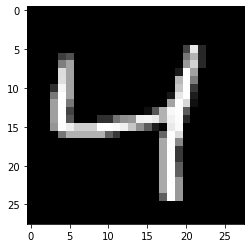

In [10]:
imagem = next(iter(train_loader))[0][2].view(28, 28) # (1, 1, 28, 28)
plt.imshow(imagem, cmap='gray')

In [11]:
imagem.shape

torch.Size([28, 28])

(array([669.,  10.,   7.,   9.,   8.,   5.,  27.,   5.,   8.,  36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

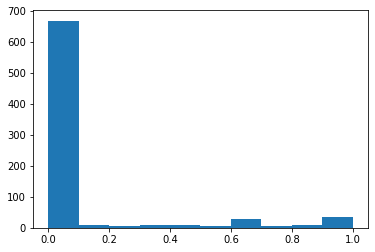

In [12]:
plt.hist(imagem.view(-1))

## Etapa 3: Construção do modelo

In [13]:
class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (28 - 3 + 1) / 1 = 26x26
    # pooling 1: 13x13
    # convolução 2: (13 - 3 + 1) / 1 = 11x11
    # pooling 2: 5x5
    # 5 * 5 * 32
    # 800 -> 128 -> 128 -> 10
    self.linear1 = nn.Linear(in_features=32*5*5, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X

In [14]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Etapa 4: Treinamento do modelo

In [15]:
device = torch.device('cuda') if torch.cuda.is_available else torch.devide('cpu')
device

device(type='cuda')

In [16]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [17]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
                
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy

              
        # Imprimindo os dados referentes a este loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, 
                                   accuracy), end = '\r')
        
    # Imprimindo os dados referentes a esta época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader), 
                     running_accuracy/len(loader)))

In [18]:
for epoch in range(5):
  print('Treinando...')
  training_loop(train_loader, epoch)
  net.eval()
  print('Validando...')
  training_loop(test_loader, epoch)
  net.train()

Treinando...


<ipython-input-17-24f7e8ac0aa5>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda 0.15832 - precisão 0.95330
Validando...
ÉPOCA   1 FINALIZADA: perda 0.15538 - precisão 0.95421
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.05351 - precisão 0.98419
Validando...
ÉPOCA   2 FINALIZADA: perda 0.06462 - precisão 0.98161
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.03963 - precisão 0.98852
Validando...
ÉPOCA   3 FINALIZADA: perda 0.04947 - precisão 0.98477
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.03202 - precisão 0.99030
Validando...
ÉPOCA   4 FINALIZADA: perda 0.04969 - precisão 0.98477
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.02535 - precisão 0.99198
Validando...
ÉPOCA   5 FINALIZADA: perda 0.02986 - precisão 0.99090


## Etapa 5: Avaliação do modelo

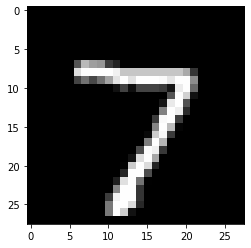

In [19]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')

In [20]:
# (1, 1, 28, 28) - (batch_size, número de canais, altura largura)
imagem.shape

torch.Size([28, 28])

In [21]:
imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [22]:
net.eval()
imagem = imagem.to(device)

In [23]:
previsao = net.forward(imagem)

In [24]:
previsao

tensor([[-4.7575e+00, -2.1924e+00, -1.4534e+00, -2.0985e+00, -3.0660e+00,
         -6.1123e+00, -8.8695e+00,  9.8286e+00, -4.7865e+00, -5.9603e-03]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
previsao = F.softmax(previsao)

<ipython-input-25-4836b3525bc1>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


In [26]:
previsao

tensor([[4.6270e-07, 6.0161e-06, 1.2596e-05, 6.6083e-06, 2.5114e-06, 1.1937e-07,
         7.5763e-09, 9.9992e-01, 4.4945e-07, 5.3563e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [27]:
previsao = previsao.cpu().detach().numpy()

In [28]:
previsao

array([[4.6269616e-07, 6.0160864e-06, 1.2595901e-05, 6.6083367e-06,
        2.5113700e-06, 1.1937358e-07, 7.5763316e-09, 9.9991775e-01,
        4.4945125e-07, 5.3562941e-05]], dtype=float32)

In [29]:
resultado = np.argmax(previsao)

In [30]:
resultado

7